```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 讀檔

In [2]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [3]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    pre_df = select_data(df)
    
    if is_train_data:
        segs = split_segments_overlap(pre_df, seq_len, shift)
    else:
        segs = split_segments(pre_df, seq_len)
    
    return segs

In [4]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    pair_data = []
    files = os.listdir(root_folder)
    if file_index is not None:
        files = files[file_index[0]:file_index[1]]

    for folder in files:
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [5]:
datapoint_per_second = 20
duration = 2
seq_len = 25
shift = 15  # the shfit of the data
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [6]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [7]:
train_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[0, 8], is_train_data=True)
valid_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[8, 10], is_train_data=False)

train_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[0, 8], is_train_data=True)
valid_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[8, 10], is_train_data=False)

train_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[0, 8], is_train_data=True)
valid_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[8, 10], is_train_data=False)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./pocket/202302132108
./pocket/202302132108/source ./pocket/202302132108/target
./pocket/202302131750
./pocket/2023021

In [8]:
print(len(train_front_pocket_pair_data), len(train_pocket_pair_data), len(train_swing_pair_data))

2697 2640 2559


In [9]:
train_front_pocket_pair_data[0][0][0], train_front_pocket_pair_data[0][2][0]

(array([-1.14233120e+00, -1.94808760e-01,  1.75476462e+00, -2.18800381e-01,
        -2.56263137e-01, -2.19771296e-01,  1.68020420e+01, -1.84701080e+01,
         3.61005859e+01,  1.67575811e+09]),
 array([-4.94412891e-01,  3.02118031e-01, -7.15015656e-01, -5.08982837e-02,
        -8.86559859e-02,  1.07779831e-01, -3.95247726e+01, -8.10098648e+00,
        -1.99851685e+01,  1.67575811e+09]))

#### Check for time alignment

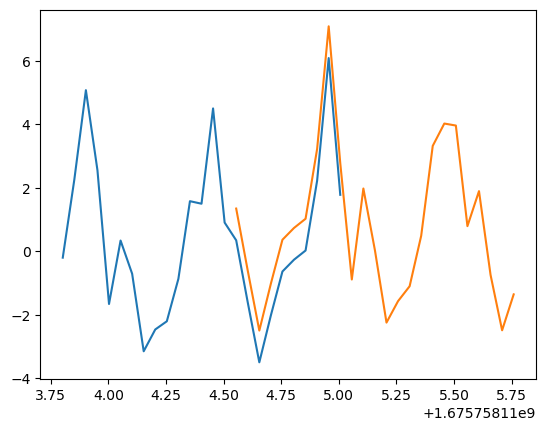

In [10]:
plt.figure()

plt.plot(train_front_pocket_pair_data[0][0][:, -1], train_front_pocket_pair_data[0][0][:, 1])
plt.plot(train_front_pocket_pair_data[1][0][:, -1], train_front_pocket_pair_data[1][0][:, 1] + 1)

plt.show()

### recurrence plot function

In [23]:
def generate_recurrence_plot(data):
#     if data.shape[1] == 1:
#         error = data.T - data
#         max_error = np.max(np.abs(error))
#     else:
    error = data.T[:, None, :] - data.T[:, :, None]
    max_error = np.abs(error).max(axis=-1).max(axis=-1)
    max_error = max_error[:, None, None]
    
    return 1 - 0.5 * (1 - error / max_error)

#### check 1 channel data

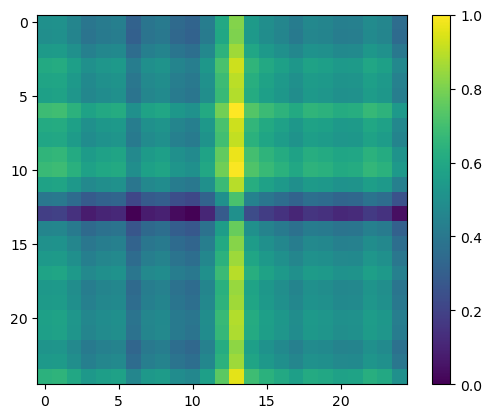

In [24]:
td = valid_front_pocket_pair_data[0][0][:, 0:1]
rp = generate_recurrence_plot(td)

plt.figure()
plt.imshow(rp[0])
plt.colorbar()
plt.show()

del td, rp

### check multi channels data

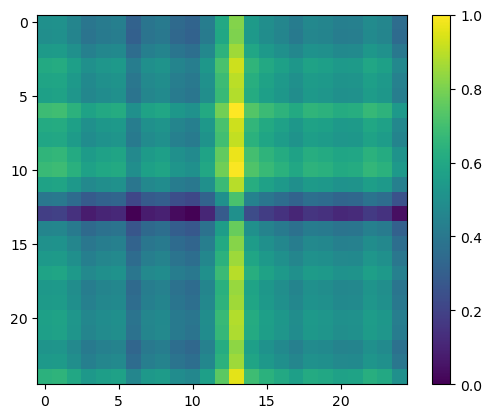

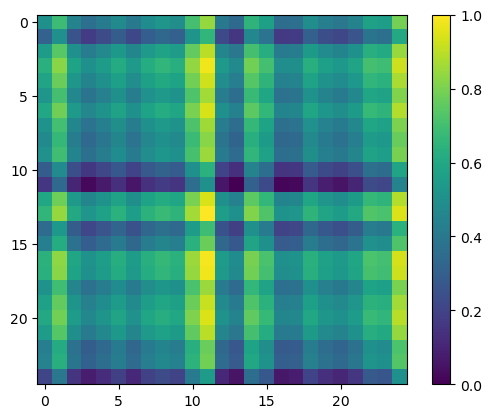

In [25]:
td = valid_front_pocket_pair_data[0][0][:, 0:2]
rp = generate_recurrence_plot(td)

plt.figure()
plt.imshow(rp[0])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(rp[1])
plt.colorbar()
plt.show()

del td, rp

# 建立dataloader

In [26]:
def generate_recurrence_plot_tensor(data):
    data = data.permute(0, 2, 1)  # (bs, seq_len, channel) -> (bs, channel, seq_len)
    error = data[:, :, None, :] - data[:, :, :, None]  # (bs, channel, 1, seq_len) - (bs, channel, seq_len, 1) = (bs, channel, seq_len, seq_len)
    max_error = error.abs().max(dim=3).values.max(dim=2).values  # find max values for each batch and channel
    max_error = max_error[:, :, None, None]  # (bs, channel) -> (bs, channel, 1, 1)
    
    return 1 - 0.5 * (1 - error / max_error)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [83]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [80]:
# def generator_loss(z_imu, target_imu, predict_mag, target_mag):
#     imu_loss = mse_loss(z_imu, target_imu)
#     mag_loss = mse_loss(predict_mag, target_mag)
#     d1_loss = div_loss(predict_mag, target_mag)

#     total_loss = imu_loss + mag_loss #+ d1_loss
#     return total_loss, imu_loss, mag_loss, d1_loss

def generator_loss(predict_mag, target_mag):
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)

    total_loss = mag_loss
    return total_loss, (mag_loss)

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [19]:
train_data = train_front_pocket_pair_data + train_pocket_pair_data + train_swing_pair_data
valid_data = valid_front_pocket_pair_data + valid_pocket_pair_data + valid_swing_pair_data

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=512)

In [20]:
batch = next(iter(valid_loader))

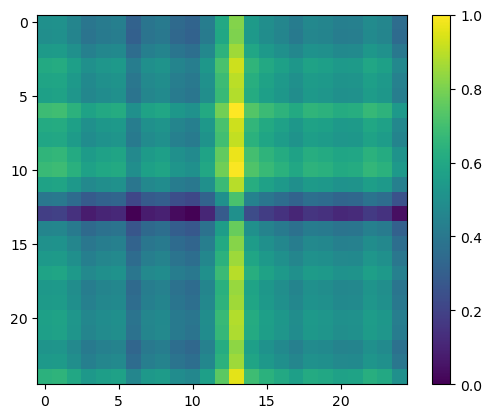

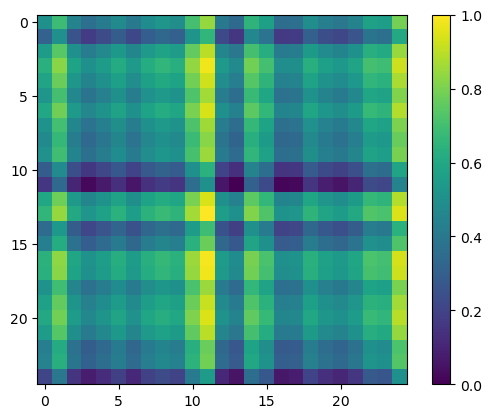

In [27]:
sd, _, _, _ = batch
rp = generate_recurrence_plot_tensor(sd)

plt.figure()
plt.imshow(rp[0, 0])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(rp[0, 1])
plt.colorbar()
plt.show()

del sd, rp

In [22]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [29]:
class CNNBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, (3, 3)),
            nn.SELU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(),
        )
        
    def forward(self, x):
        return self.nn(x)


class Classifier(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            CNNBlock(6, 32),
            CNNBlock(32, 64),
            CNNBlock(64, 128),
        )
        
        self.last = nn.Sequential(
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 96),
            nn.LeakyReLU(),
            nn.Linear(96, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = self.cnn(x)

        h = h.reshape(len(x), -1)
        
        out = self.last(h)
        
        return out
    
    def predict_label(self, x):
        predict_probability = self(x)
        predict_probability = predict_probability.reshape((-1, self.num_of_classes))
        _, predict_classes = torch.max(predict_probability, 1)
        one_hot = F.one_hot(predict_classes, num_classes=self.num_of_classes).to(device).float()
        
        return predict_probability, one_hot, predict_classes

In [86]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)


class CalibartionModel(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super().__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            CNNBlock(6, 32),
            CNNBlock(32, 64),
            CNNBlock(64, 128),
        )
        
        self.pos_encoder = PositionalEncoding(128, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=128, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.mag_upsample = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
        )
        
        self.mag_downsample = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 3),
        )
        
    def forward(self, recurrence_plot, source_mag):
        # step 1
        h = self.cnn(recurrence_plot)  # (bs, 6, 25, 25) -> (bs, 128, 1, 1)
        h = h.reshape(len(recurrence_plot), 128, -1)  # (bs, 128)
        
        # step 2
        h = self.pos_encoder(h)
        h = self.encoder(h)
        
        # step 3
        source_mag_z = self.mag_upsample(source_mag)
        
        # step 4
        pred_latent = self.decoder(source_mag_z, h)
        
        # step 4
        pred_mag = self.mag_downsample(pred_latent)
        
        return pred_mag

In [84]:
EPOCH = 2000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

# Train classifier

In [26]:
# classifier = Classifier(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.001)
# lr_scheduler_C = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_C, T_max=50, eta_min=0.0000001)

In [100]:
model = CalibartionModel(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0000001)

In [101]:
output = model(torch.empty(1, 6, 25, 25).to(device), torch.empty(1, 25, 3).to(device))
output.shape

torch.Size([1, 25, 3])

In [102]:
from torchinfo import summary
summary(model, input_size=[(1, 6, 25, 25), (1, 25, 3)])

Layer (type:depth-idx)                        Output Shape              Param #
CalibartionModel                              [1, 25, 3]                --
├─Sequential: 1-1                             [1, 128, 1, 1]            --
│    └─CNNBlock: 2-1                          [1, 32, 11, 11]           --
│    │    └─Sequential: 3-1                   [1, 32, 11, 11]           1,760
│    └─CNNBlock: 2-2                          [1, 64, 4, 4]             --
│    │    └─Sequential: 3-2                   [1, 64, 4, 4]             18,496
│    └─CNNBlock: 2-3                          [1, 128, 1, 1]            --
│    │    └─Sequential: 3-3                   [1, 128, 1, 1]            73,856
├─PositionalEncoding: 1-2                     [1, 128, 128]             --
│    └─Dropout: 2-4                           [1, 128, 128]             --
├─TransformerEncoder: 1-3                     [1, 128, 128]             --
│    └─ModuleList: 2-5                        --                        --
│    │   

In [103]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [104]:
def train(model, dataloader, optimizer):
    model.train()

    losses = []
    accuracies = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :6]
        source_mag = source_data[:, :, 6:9]
        
        target_mag = target_data[:, :, 6:9].to(device)
        
        recurrence_plot = generate_recurrence_plot_tensor(source_imu)

        #############
        # generator #
        #############
        predict_mag = model(recurrence_plot, source_mag)
        
        loss, _ = generator_loss(predict_mag, target_mag)
        
        # backward
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(losses)

In [105]:
def evalute(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 6:9]

            target_mag = target_data[:, :, 6:9].to(device)

            recurrence_plot = generate_recurrence_plot_tensor(source_imu)

            #############
            # generator #
            #############
            predict_mag = model(recurrence_plot, source_mag)

            loss, _ = generator_loss(predict_mag, target_mag)
            
            losses.append(loss.item())
            
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(losses)

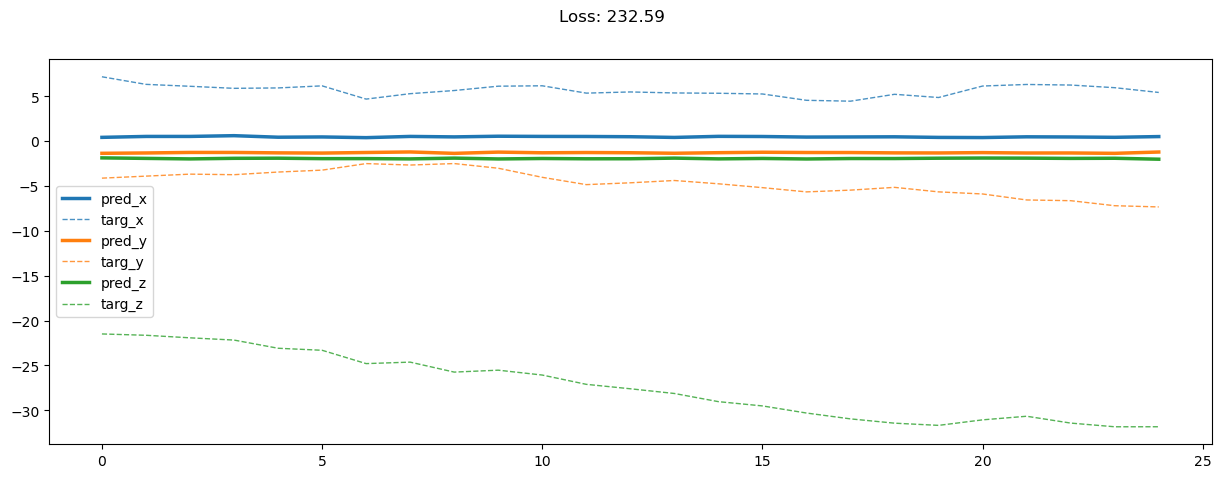

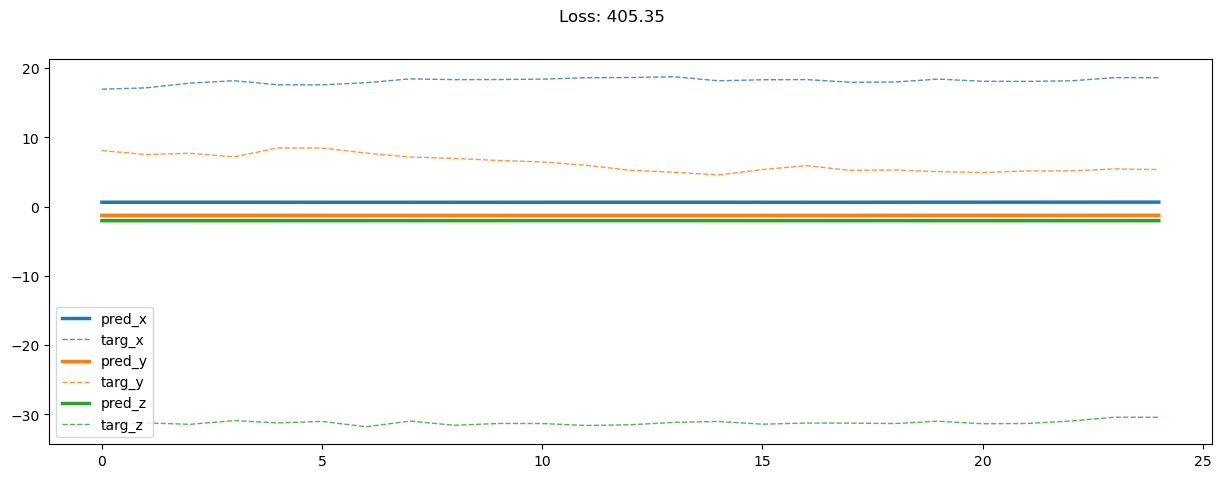

00010: train loss: 605.290   valid loss: 591.670
00020: train loss: 570.133   valid loss: 561.068


In [ ]:
draw = True

for epoch in range(2000):
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss = train(model, train_loader, optimizer)
    lr_scheduler.step()
    valid_loss = evalute(model, valid_loader)
    
    draw = False
    
    if (epoch + 1) % 10 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep}: train loss: {train_loss:2.3f}   valid loss: {valid_loss:2.3f}')

In [28]:
def train_C(model, dataloader, optimizer):
    model.train()

    losses = []
    accuracies = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        sequences = torch.concat([source_data[:, :, :6], target_data[::3, :, :6]])
        labels = torch.concat([source_label, target_label[::3]])
        
        sequences = sequences.to(device)
        recurrence_plot = generate_recurrence_plot_tensor(sequences)
        
        one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

        #############
        # generator #
        #############
        predict_probability = model(recurrence_plot)
        
        predict_probability = predict_probability.reshape((-1, num_of_classes))
        one_hot = one_hot.reshape((-1, num_of_classes))
        loss = ce_loss(predict_probability, one_hot)
        
        # backward
        loss.backward()
        optimizer.step()
        
        _, predict_classes = torch.max(predict_probability, 1)
        predict_classes = predict_classes.cpu().detach().numpy()
        _, labels = torch.max(one_hot, 1)
        labels = labels.cpu().detach().numpy()
        
        losses.append(loss.item())
        accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [29]:
def evalute_C(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            
            sequences = torch.concat([source_data[:, :, :6], target_data[:, :, :6]])
            labels = torch.concat([source_label, target_label])
            
            sequences = sequences.to(device)
            recurrence_plot = generate_recurrence_plot_tensor(sequences)
            
            one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

            #############
            # generator #
            #############
            predict_probability = model(recurrence_plot)
            
            predict_probability = predict_probability.reshape((-1, num_of_classes))
            one_hot = one_hot.reshape((-1, num_of_classes))
            loss = ce_loss(predict_probability, one_hot)

            _, predict_classes = torch.max(predict_probability, 1)
            predict_classes = predict_classes.cpu().detach().numpy()
            _, labels = torch.max(one_hot, 1)
            labels = labels.cpu().detach().numpy()
            
            losses.append(loss.item())
            accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [30]:
for epoch in range(2000):
    train_loss, train_acc = train_C(classifier, train_loader, optimizer_C)
    lr_scheduler.step()
    valid_loss, valid_acc = evalute_C(classifier, valid_loader)
    
    if (epoch + 1) % 100 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep}: train loss: {train_loss:2.3f}, acc: {train_acc:2.3f}   valid loss: {valid_loss:2.3f}, acc: {valid_acc:2.3f}')

00100: train loss: 1.020, acc: 0.715   valid loss: 0.899, acc: 0.828
00200: train loss: 0.885, acc: 0.906   valid loss: 0.813, acc: 0.962
00300: train loss: 0.857, acc: 0.892   valid loss: 0.792, acc: 0.956
00400: train loss: 0.779, acc: 0.968   valid loss: 0.760, acc: 0.986
00500: train loss: 0.990, acc: 0.754   valid loss: 0.814, acc: 0.928
00600: train loss: 0.775, acc: 0.968   valid loss: 0.759, acc: 0.984
00700: train loss: 0.768, acc: 0.975   valid loss: 0.778, acc: 0.966
00800: train loss: 0.790, acc: 0.954   valid loss: 0.771, acc: 0.971
00900: train loss: 0.767, acc: 0.976   valid loss: 0.770, acc: 0.972
01000: train loss: 0.761, acc: 0.982   valid loss: 0.757, acc: 0.987
01100: train loss: 0.762, acc: 0.981   valid loss: 0.763, acc: 0.981
01200: train loss: 0.772, acc: 0.971   valid loss: 0.757, acc: 0.987
01300: train loss: 0.762, acc: 0.982   valid loss: 0.761, acc: 0.983
01400: train loss: 0.766, acc: 0.977   valid loss: 0.787, acc: 0.957
01500: train loss: 0.761, acc: 0.9

In [30]:
sd, sl, _, _ = next(iter(valid_loader))
recurrence_plot = generate_recurrence_plot_tensor(sd[:, :, :6])
prob, onehot, res = classifier.predict_label(recurrence_plot.cuda())
sl, res

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [31]:
#del sd, sl, recurrence_plot, prob, onehot, res

# Train whole model

In [ ]:
class NotSimpleTransformer(nn.Module):
    def __init__(self,seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()

In [ ]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [ ]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
def train(dataloader, draw=False):
    model.train()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :, :6]
        target_mag = target_data[:, :, :, 6:9]

        # generate mag
        class_result = classifier.predict_label(source_imu)
        
        z_imu, predict_mag = model(source_imu, source_mag, class_result)
        
        # generator loss
        gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [ ]:
def evalute(dataloader, draw=False):
    model.eval()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            class_result = classifier.predict_label(source_imu)
            
            z_imu, predict_mag = model(source_imu, source_mag, class_result)

            # generator loss
            gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [ ]:
from torchinfo import summary
summary(model, input_size=[(1, 7, 21, 6), (1, 7, 21, 3), (1, 7, 4)])

In [ ]:
for param in classifier.parameters():
    param.requires_grad = False

In [ ]:
def check():
    for source_data, source_label, target_data, target_label in train_loader:
        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        predict_probability, _ = classifier(source_imu)
        predict_probability = predict_probability.reshape((-1, num_of_classes))
        _, predict_classes = torch.max(predict_probability, 1)
        one_hot = F.one_hot(predict_classes, num_classes=num_of_classes).to(device).float()
        class_result = one_hot.reshape(-1, chunk_size, num_of_classes)
        
        ### step 1
        h_imu = model.imu_layer(source_imu)
        h_imu = h_imu.reshape((len(source_imu), chunk_size, -1))
        h_imu = model.pos_encoder(h_imu)
        
        h_mag = model.mag_layer(source_mag)
        h_mag = h_mag.reshape((len(source_mag), chunk_size, -1))
        h_mag = model.pos_encoder(h_mag)
        
        ### step 2
        z = model.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), chunk_size, seq_len, -1))
        z_imu = model.nn(z_imu)

        z_class = torch.concat([z, class_result], dim=-1)
        task_latent = model.task_controller_net(z_class)
        
        ### step 3
        pred_latent = model.decoder(h_mag, z)
        pred_mag = pred_latent.reshape((len(source_mag), chunk_size, seq_len, -1))
        
        pred_mag = pred_mag + task_latent[:, :, None, :]
        pred_mag = model.mag_last(pred_mag)
        
        
        return z_imu, pred_mag

In [ ]:
draw = False

for epoch in range(EPOCH):
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}')

In [ ]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]
            
            class_result = classifier.predict_label(source_imu)

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag, class_result)
            

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [ ]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::5000]:
    plot_result(rs)

In [ ]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::50]:
    plot_result(rs)